In [1]:
%matplotlib inline
import pystokes, autograd.numpy as np, matplotlib.pyplot as plt
from autograd import grad

In [2]:
# particle radius, self-propulsion speed, number and fluid viscosity
b, Np, eta = 1.0, 2, 0.1
PI = 3.14159265359

In [3]:
## matrix elements for i=j
G01s = 1./(6*PI*eta*b)
G02a = 1./(4*PI*eta*b)
G02s = 3./(20*PI*eta*b)

In [4]:
## basics for i!=j, hard-coded version is faster (see below)

def G(xij,yij,zij, alpha,beta): #G_alpha beta
    rij = np.array([xij,yij,zij])
    r = np.linalg.norm(rij)
    return ((np.identity(3)/r + np.outer(rij,rij)/r**3)/(8*eta*PI))[alpha,beta]

def delG(xij,yij,zij, alpha,beta,gamma): #G_alpha beta, gamma = nabla_gamma G_alpha beta
    rij = np.array([xij,yij,zij])
    r = np.linalg.norm(rij)
    t1 = -np.einsum('ij,k',np.identity(3),rij)/r**3
    t2 = (np.einsum('ik,j',np.identity(3),rij) 
           + np.einsum('jk,i',np.identity(3),rij))/r**3
    t3 = -3*np.einsum('i,j,k',rij,rij,rij)/r**5
    return ((t1 + t2 + t3)/(8*eta*PI))[alpha,beta,gamma]

def lapG(xij,yij,zij, alpha,beta): # nabla^2 G_alpha beta
    rij = np.array([xij,yij,zij])
    r = np.linalg.norm(rij)
    return ((np.identity(3)/r**3 - 3*np.outer(rij,rij)/r**5)/(4*eta*PI))[alpha,
                                                                       beta]

In [5]:
epsilon = lambda i,j,k:(i-j)*(j-k)*(k-i)/2.

In [6]:
def delGauto(xij,yij,zij, alpha,beta,gamma):
    return grad(G,gamma)(xij,yij,zij, alpha,beta)

In [9]:
%%time
delG(0.,1.,3., 1,2,1) ##hard-coded

CPU times: user 253 µs, sys: 0 ns, total: 253 µs
Wall time: 248 µs


0.026422836354853946

In [10]:
%%time
delGauto(0.,1.,3., 1,2,1) ##autograd

CPU times: user 33.4 ms, sys: 0 ns, total: 33.4 ms
Wall time: 32.7 ms


0.02642283635485395

--> use hard-coded version whenever possible

In [11]:
## RBM matrix elements: G^LL for i!=j

def G1s1s(xij,yij,zij, alpha,beta):
    return (G(xij,yij,zij, alpha,beta)
            +b**2/3.*lapG(xij,yij,zij, alpha,beta))

def G1s2a(xij,yij,zij, alpha,beta):
    g1s2a=0.
    for nu in range(3):
        for eta in range(3):
            g1s2a += epsilon(beta,nu,eta)*delG(xij,yij,zij,alpha,eta,nu)
    return -0.5*b*g1s2a

def G2a1s(xij,yij,zij, alpha,beta):
    g2a1s=0
    for nu in range(3):
        for eta in range(3):
            g2a1s += epsilon(alpha,nu,eta)*delG(xij,yij,zij,eta,beta,nu)
    return 0.5*g2a1s

def G2a2a(xij,yij,zij, alpha,beta):
    g2a2a=0
    for mu in range(3):
        for kappa in range(3):
            g2a2a += epsilon(alpha,mu,kappa)*delG1s2a(xij,yij,zij, kappa,beta,mu)
    return -0.25*b*g2a2a

## auxiliary functions 
def delG1s2a(xij,yij,zij, kappa,beta,mu):
        return grad(G1s2a, mu)(xij,yij,zij, kappa,beta)

In [12]:
## G^LH and G^HL matrix elements for i!=j

def G1s2s(xij,yij,zij, alpha,kappa1,beta):
    g1s2s = 0
    g1s2s += (delG(xij,yij,zij, alpha,beta,kappa1)
              + delG(xij,yij,zij, alpha,kappa1,beta))
    g1s2s += 4*b*b/15.*(dellapG(xij,yij,zij, alpha,beta,kappa1) 
                        + dellapG(xij,yij,zij, alpha,kappa1,beta))
    return -0.5*b*g1s2s
              
def G2a2s(xij,yij,zij, alpha,kappa1,beta):
    g2a2s=0
    for nu in range(3):
        for eta in range(3):
            g2a2s += epsilon(alpha,nu,eta)*(deldelG(xij,yij,zij, eta,beta,kappa1,nu)
                                            + deldelG(xij,yij,zij, eta,kappa1,beta,nu))
    return -0.25*b*g2a2s

def G2s1s(xij,yij,zij, alpha,gamma1,beta):
    g2s1s = 0
    g2s1s += (delG(xij,yij,zij, alpha,beta,gamma1)
              + delG(xij,yij,zij, gamma1,beta,alpha))
    g2s1s += 4*b*b/15.*(dellapG(xij,yij,zij, alpha,beta,gamma1) 
                        + dellapG(xij,yij,zij, gamma1,beta,alpha))
    return 0.5*b*g2s1s

def G2s2a(xij,yij,zij, alpha,gamma1,mu):
    g2s2a=0
    for kappa1 in range(3):
        for beta in range(3):
            g2s2a += epsilon(beta,kappa1,mu)*(deldelG(xij,yij,zij, gamma1,beta,alpha,kappa1)
                                            + deldelG(xij,yij,zij, alpha,beta,gamma1,kappa1))
    return 0.25*b*b*g2s2a

## G^HH matrix element for i!=j

def G2s2s(xij,yij,zij, alpha,gamma1,kappa1,beta):
    g2s2s = (deldelG(xij,yij,zij, alpha,beta,gamma1,kappa1) 
              + deldelG(xij,yij,zij, gamma1,beta,alpha,kappa1))
    g2s2s += (deldelG(xij,yij,zij, alpha,kappa1,gamma1,beta) 
              + deldelG(xij,yij,zij, gamma1,kappa1,alpha,beta))
    g2s2s += b*b/5.*(deldellapG(xij,yij,zij, alpha,beta,gamma1,kappa1)
                     + deldellapG(xij,yij,zij, gamma1,beta,alpha,kappa1))
    g2s2s += b*b/5.*(deldellapG(xij,yij,zij, alpha,kappa1,gamma1,beta)
                     + deldellapG(xij,yij,zij, gamma1,kappa1,alpha,beta))
    return -0.25*b*b*g2s2s
              
## auxiliary functions    
def dellapG(xij,yij,zij, alpha,beta,kappa1):
    return grad(lapG, kappa1)(xij,yij,zij, alpha,beta)

def deldelG(xij,yij,zij, eta,beta,kappa1,nu):
    return grad(delG, nu)(xij,yij,zij, eta,beta,kappa1)

def deldellapG(xij,yij,zij, alpha,beta,gamma1,kappa1):
    return grad(dellapG, kappa1)(xij,yij,zij, alpha,beta,gamma1)

In [13]:
## uniaxial parametrisation
def Y2(ex,ey,ez, alpha,beta):
    e = np.array([ex,ey,ez])
    return (3*np.outer(e,e) - np.identity(3))[alpha,beta]

In [14]:
## fill tensors for tensorsolve from indices above
## RBM
def tensorG1s1s(xij,yij,zij):
    g=np.zeros([3,3])
    for alpha in range(3):
        for beta in range(3):
            g[alpha,beta]=G1s1s(xij,yij,zij, alpha,beta)
    return g

def tensorG1s2a(xij,yij,zij):
    g=np.zeros([3,3])
    for alpha in range(3):
        for beta in range(3):
            g[alpha,beta]=G1s2a(xij,yij,zij, alpha,beta)
    return g

def tensorG2a1s(xij,yij,zij):
    g=np.zeros([3,3])
    for alpha in range(3):
        for beta in range(3):
            g[alpha,beta]=G2a1s(xij,yij,zij, alpha,beta)
    return g

def tensorG2a2a(xij,yij,zij):
    g=np.zeros([3,3])
    for alpha in range(3):
        for beta in range(3):
            g[alpha,beta]=G2a2a(xij,yij,zij, alpha,beta)
    return g


## higher order
def tensorG1s2s(xij,yij,zij):
    g=np.zeros([3,3,3])
    for alpha in range(3):
        for beta in range(3):
            for gamma in range(3):
                g[alpha,beta,gamma]=G1s2s(xij,yij,zij, alpha,beta,gamma)
    return g

def tensorG2a2s(xij,yij,zij):
    g=np.zeros([3,3,3])
    for alpha in range(3):
        for beta in range(3):
            for gamma in range(3):
                g[alpha,beta,gamma]=G2a2s(xij,yij,zij, alpha,beta,gamma)
    return g

def tensorG2s1s(xij,yij,zij):
    g=np.zeros([3,3,3])
    for alpha in range(3):
        for beta in range(3):
            for gamma in range(3):
                g[alpha,beta,gamma]=G2s1s(xij,yij,zij, alpha,beta,gamma)
    return g

def tensorG2s2a(xij,yij,zij):
    g=np.zeros([3,3,3])
    for alpha in range(3):
        for beta in range(3):
            for gamma in range(3):
                g[alpha,beta,gamma]=G2s2a(xij,yij,zij, alpha,beta,gamma)
    return g

def tensorG2s2s(xij,yij,zij):
    g=np.zeros([3,3,3,3])
    for alpha in range(3):
        for beta in range(3):
            for gamma in range(3):
                for delta in range(3):
                    g[alpha,beta,gamma,delta]=G2s2s(xij,yij,zij, alpha,beta,gamma,delta)
    return g


##auxiliary tensors for uniaxial parametrisation
def tensorY2(ex,ey,ez):
    e = np.array([ex,ey,ez])
    return (3*np.outer(e,e) - np.identity(3))

def tensorG2s2sY2(xij,yij,zij,ex,ey,ez): ##LHS in lin system
    return np.einsum('ijkl,kl',tensorG2s2s(xij,yij,zij),tensorY2(ex,ey,ez))

def tensorG1s2sY2(xij,yij,zij,ex,ey,ez): 
    return np.einsum('ikl,kl',tensorG1s2s(xij,yij,zij),tensorY2(ex,ey,ez))

def tensorG2a2sY2(xij,yij,zij,ex,ey,ez): 
    return np.einsum('ikl,kl',tensorG2a2s(xij,yij,zij),tensorY2(ex,ey,ez))

In [15]:
def directSolve(v, o, r, F, T):
    for i in range(Np):
        v_ = np.zeros([3])
        o_ = np.zeros([3])
        for j in range(Np):
            xij = r[i]    - r[j]
            yij = r[i+Np]  - r[j+Np]
            zij = r[i+2*Np]  - r[j+2*Np]
            if i!=j:
                force  = np.array([F[j],F[j+Np], F[j+2*Np]])
                torque = np.array([T[j],T[j+Np], T[j+2*Np]])
                                
                lhs = tensorG2s2s(xij,yij,zij)
                lhs_mat = np.reshape(lhs, (9,9))
                lhs_mat_inv = np.linalg.pinv(lhs_mat)
                lhs_inv = np.reshape(lhs_mat_inv, (3,3,3,3))
                rhs = (np.dot(tensorG2s1s(xij,yij,zij), force) 
                       + 1./b * np.dot(tensorG2s2a(xij,yij,zij), torque))
                F2s = np.einsum('ijkl, kl', lhs_inv, rhs)
                
                v_ += (np.dot(tensorG1s1s(xij,yij,zij), force)
                      + 1./b * np.dot(tensorG1s2a(xij,yij,zij), torque)
                      - np.einsum('ijk,jk',tensorG1s2s(xij,yij,zij),F2s))
                
                o_ += 0.5/b*(np.dot(tensorG2a1s(xij,yij,zij), force)
                             + 1./b * np.dot(tensorG2a2a(xij,yij,zij), torque)
                             - np.einsum('ijk,jk',tensorG2a2s(xij,yij,zij),F2s))
                       
            else:
                force  = np.array([F[j],F[j+Np], F[j+2*Np]])
                torque = np.array([T[j],T[j+Np], T[j+2*Np]])
                
                v_ += G01s*force
                o_ += 1./b * G02a*torque
                
        v[i]      += v_[0]
        v[i+Np]   += v_[1]
        v[i+2*Np] += v_[2]
        
        o[i]      += o_[0]
        o[i+Np]   += o_[1]
        o[i+2*Np] += o_[2]
    return

In [16]:
%%time
## Two spheres falling next to each other

#initial position
r = np.array([0.,2.3, 0.,0., 99.,100.])

#gravity in neg z direction
F = np.array([0.,0., 0.,0., -1.,-1.])
T = np.zeros(3*Np)

# integration parameters
Nt=10; r1=np.zeros([3,Nt]); r2=np.zeros([3,Nt])
r1[:,0] = r[::Np]; r2[:,0] = r[Np-1::Np]
dt=3.;
v = np.zeros(3*Np);
o = np.zeros(3*Np)
theta1=np.zeros([3,Nt]); theta2=np.zeros([3,Nt])

for i in range(Nt-1):
    directSolve(v, o, r, F, T)
    
    r1[:,i+1] = r1[:,i] + dt*v[::Np]
    r2[:,i+1] = r2[:,i] + dt*v[Np-1::Np]
    
    theta1[:,i+1] = theta1[:,i] + dt*o[::Np]
    theta2[:,i+1] = theta2[:,i] + dt*o[Np-1::Np]
    
    # reset variables for next time step
    r[::Np] = r1[:,i+1]
    r[Np-1::Np] = r2[:,i+1]
    v = v*0
    o = o*0

print('finish')

finish
CPU times: user 39 s, sys: 33.9 ms, total: 39 s
Wall time: 39 s


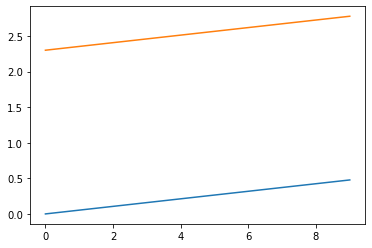

In [17]:
times = np.arange(0,Nt)
plt.plot(times, r1[0,:], times, r2[0,:])

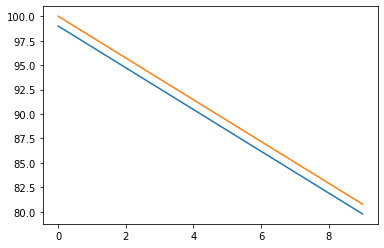

In [18]:
plt.plot(times, r1[2,:], times, r2[2,:])

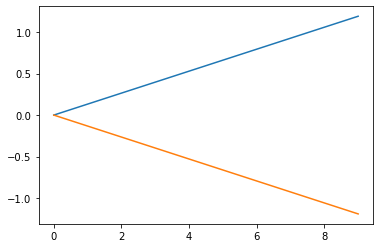

In [19]:
plt.plot(times, theta1[1,:], times, theta2[1,:])

In [24]:
Np=3

In [25]:
%%time
## Three spheres falling - are two fast ones catching up third one? 

#initial position
r = np.array([0.,2.3,1.15,  0.,0.,2.3,  100.,100.,90.])

#gravity in neg z direction
F = np.array([0.,0.,0.,  0.,0.,0.,  -1.,-1.,-1.])
T = np.zeros(3*Np)

# integration parameters
Nt=100; r1=np.zeros([3,Nt]); r2=np.zeros([3,Nt]); r3=np.zeros([3,Nt]) 
r1[:,0] = r[::Np]; r2[:,0] = r[1::Np]; r3[:,0] = r[2::Np] 
dt=3.;
v = np.zeros(3*Np);
o = np.zeros(3*Np)
theta1=np.zeros([3,Nt]); theta2=np.zeros([3,Nt]); theta3=np.zeros([3,Nt])

for i in range(Nt-1):
    directSolve(v, o, r, F, T)
    
    r1[:,i+1] = r1[:,i] + dt*v[::Np]
    r2[:,i+1] = r2[:,i] + dt*v[1::Np]
    r3[:,i+1] = r3[:,i] + dt*v[2::Np]
    
    theta1[:,i+1] = theta1[:,i] + dt*o[::Np]
    theta2[:,i+1] = theta2[:,i] + dt*o[1::Np]
    theta3[:,i+1] = theta3[:,i] + dt*o[2::Np]
    
    # reset variables for next time step
    r[::Np] = r1[:,i+1]
    r[1::Np] = r2[:,i+1]
    r[2::Np] = r3[:,i+1]
    v = v*0
    o = o*0

print('finish')

finish
CPU times: user 24min 21s, sys: 824 ms, total: 24min 22s
Wall time: 24min 22s


ValueError: x and y must have same first dimension, but have shapes (10,) and (100,)

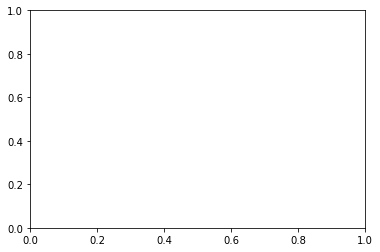

In [26]:
plt.plot(times, r1[2,:], times, r2[2,:], times, r3[2,:])

In [ ]:
## test tensorsolve and pseudo_inverse

In [41]:
xij = -3.; yij = 0.; zij = 0.
torque = np.array([0.,0.,0.])
force = np.array([0., 0., -10.])

lhs = tensorG2s2s(xij,yij,zij)
rhs = (np.dot(tensorG2s1s(xij,yij,zij), force) 
            + 1./b * np.dot(tensorG2s2a(xij,yij,zij), torque))


In [48]:
ex, ey, ez = np.array([0., 0., 1.])
matrix = tensorG2s2sY2(xij,yij,zij, ex, ey, ez)
matrix.shape

(3, 3)

In [66]:
matrix = np.reshape(lhs, (9,9))
matrix_inv = np.linalg.pinv(matrix)
lhs_inv = np.reshape(matrix_inv, (3,3,3,3))

In [68]:
Delta = np.einsum('ijkl,klmn', lhs_inv, lhs)

In [74]:
tensorDelta = (0.5*(np.einsum('mg,nd',np.identity(3),np.identity(3))
                    + np.einsum('md,ng',np.identity(3),np.identity(3)))
               -1./3.*np.einsum('mn,gd',np.identity(3),np.identity(3)))
    

In [79]:
np.allclose(tensorDelta,Delta)

True

In [81]:
F2s = np.einsum('ijkl, kl', lhs_inv, rhs)

In [87]:
F2s

array([[ 0.        ,  0.        , -2.75862069],
       [ 0.        ,  0.        ,  0.        ],
       [-2.75862069,  0.        ,  0.        ]])